Text(0.5,1,'Vibrations over time')

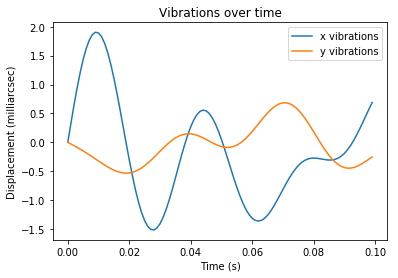

In [9]:
# make vibration data

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline

total_time = 0.1
sampling_freq = 1000
time_steps = np.arange(0, total_time, 1.0/sampling_freq)

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

def make_vibe(N_vibrations, freq, total_time):
    vib_freqs    = np.random.uniform(low=10.0, high=500.0, size=N_vibrations)  # Hz
    vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vibrations) # milliarcsecond
    vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vibrations)  # radians

    true_positions = np.zeros((len(time_steps),2))

    for i in range(N_vibrations):
        y_init_of_t = vib_amps[i] * np.sin(vib_freqs[i] * time_steps)
        x_init_of_t = np.zeros(len(time_steps))
        positions_init = np.vstack((x_init_of_t, y_init_of_t))
        rotated_positions = np.dot(rotation_matrix(vib_pa[i]) , positions_init)
        true_positions = true_positions + np.transpose(rotated_positions)
        
    '''overall formula is:
        x(t) = sum of -vib_amps[i] * sin vib_pa[i] * sin(vib_freqs[i] * t)
        y(t) = sum of +vib_amps[i] * cos vib_pa[i] * sin(vib_freqs[i] * t)
        so the amplitude of x at a particular frequency is vib_amps * sin vib_pa
                and that of y at a particular frequency is vib_amps * cos vib_pa
    '''
    
    return true_positions, vib_freqs, vib_amps, vib_pa

true_positions, vib_freqs, vib_amps, vib_pa = make_vibe(5, 1000, 0.1)
dx = true_positions[:,0]
dy = true_positions[:,1]

plt.figure()
plt.plot(time_steps, dx, label='x vibrations')
plt.plot(time_steps, dy, label='y vibrations')

plt.xlabel("Time (s)")
plt.ylabel("Displacement (milliarcsec)")
plt.legend()
plt.title("Vibrations over time")

Text(0.5,1,'FFT against applied frequencies')

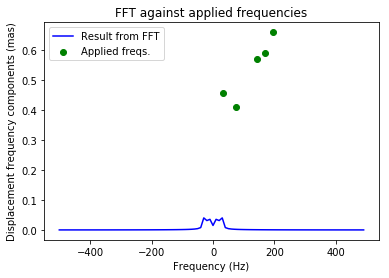

In [10]:
# do the FFT

dt = 1/sampling_freq
freqs = np.fft.fftfreq(dx.size, dt)
mode_amps_x, mode_amps_y = np.fft.fft(dx) * dt, np.fft.fft(dy) * dt

# shifting for convenient plot
freqs = np.fft.fftshift(freqs)
mode_amps_x, mode_amps_y = np.fft.fftshift(mode_amps_x), np.fft.fftshift(mode_amps_y)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Displacement frequency components (mas)")
plt.plot(freqs, np.abs(mode_amps_x), color='b', label='Result from FFT')
plt.scatter(vib_freqs, np.abs(vib_amps * np.sin(vib_pa)), color='g', label='Applied freqs.')
plt.legend()
plt.title("FFT against applied frequencies")
# y plot is similar

Text(0.5,1,'FFT against applied frequencies')

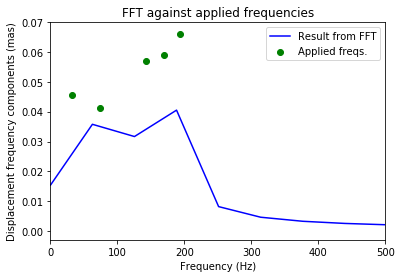

In [11]:
# it's compressed by about 2pi somehow. Can see that by doing this:

plt.figure()
plt.xlim(0, 500)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Displacement frequency components (mas)")
plt.plot(2*np.pi*freqs, np.abs(mode_amps_x), color='b', label="Result from FFT")
plt.scatter(vib_freqs, np.abs(vib_amps * np.sin(vib_pa))/10, color='g', label="Applied freqs.") # divided by 10 to see match to peaks
plt.legend()
plt.title("FFT against applied frequencies")

# points probably aren't perfectly on top of peaks because of discretization
# but what's up with the peaks vs the points on the y axis?

/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  del sys.path[0]


Text(0.5,1,'Reconstructing dx from its Fourier transform')

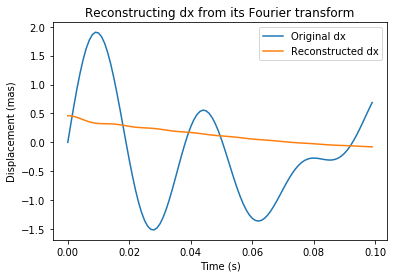

In [12]:
# unsurprisingly, if you try and get back the original signal by DTFT synthesis, it doesn't work too well

def freq_domain_dx(w):
    if w < np.min(freqs) or w > np.max(freqs):
        return 0
    else:
        return np.abs(interp1d(freqs, mode_amps_x)(w))

def dx_reconstructor(t):
    def to_integrate(w):
        return freq_domain_dx(w) * np.exp(1j*w*t)
    
    return (1/(2*np.pi)) * quad(to_integrate, np.min(freqs), np.max(freqs))[0]

dx_reconstructor = np.vectorize(dx_reconstructor)
reconstructed_dx = dx_reconstructor(time_steps)

plt.plot(time_steps, dx, label="Original dx")
plt.plot(time_steps, reconstructed_dx, label="Reconstructed dx")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (mas)")
plt.legend()
plt.title("Reconstructing dx from its Fourier transform")

Text(0.5,1,'Reconstructing dx from its Fourier transform')

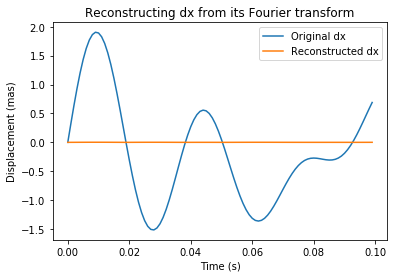

In [13]:
# okay I thought that'd be bad but that's way worse than I expected.

# Can do this more directly by inverse FFT:

reconstructed_dx = np.fft.ifft(mode_amps_x)

plt.plot(time_steps, dx, label="Original dx")
plt.plot(time_steps, np.abs(reconstructed_dx), label="Reconstructed dx")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (mas)")
plt.legend()
plt.title("Reconstructing dx from its Fourier transform")

# so the inverse FFT is all zeros for some reason